This work is taken from different sources and is a compilation rather than my original work. Please treat it as a tutorial rather than a novel work as it is meant for that. Also, while learning NLP for the first time, try writing code down on your own rather than just going through tutorials. Although repetitive, this exercise is essential for learning.

References:

https://karpathy.github.io/2015/05/21/rnn-effectiveness/

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/


# Task 1 - Language Classification using RNNs

In [1]:
#The data/names folder contains names in different languages. We want to build a text-classification model using RNNs
from __future__ import unicode_literals, print_function, division #needed for compatibility between 3.x and 2.x python versions
from io import open
import glob
import os
import torch

def findFiles(path) : return glob.glob(path)

print(findFiles('data/names/*.txt'))


['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


The code in the next cell takes all the files above and returns a dictionary of String and a List of Strings like
   {language1:[name1L1, name2L1,...], language2:[name1L2 name2L2...], ....}

In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
    c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
    
n_categories = len(all_categories)

Slusarski


Now let's try to make the input into a format our model can understand - i.e. as Tensors. We use one-hot encoding as there are only 26 letters in the alphabet and even after taking into account some extra characters like "," commas etc., the data would not be sparse if we use one-hot encdoing (57).

For more information - see sparsity in NLP (Google it).
If you need a refresher on Tensors in Pytorch, see this: https://pytorch.org/docs/stable/tensors.html
Just remember Tensors are like matrices in Math and you should be fine.

For how "Enumerate" in python works, see https://www.geeksforgeeks.org/enumerate-in-python/

In [3]:
n = len(all_letters)
n

57

In [4]:
def letterToIndex(l):
    return all_letters.find(l)

def tensorFromLetter(l): #<1xn sized tensor
    tensor = torch.zeros(1, n)
    tensor[0][letterToIndex(l)] = 1
    return tensor

def lineToTensorArray(line): #returns no of letters x 1 x n sized tensor
    tensor = torch.zeros(len(line), 1, n)
    for index, letter in enumerate(line): 
        tensor[index][0][letterToIndex(letter)] = 1
    return tensor
        
print(tensorFromLetter('J'))

print(lineToTensorArray('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Now onto creating our model. We are using RNNs here. To see how they work, head on to the references mentioned in the article in the starting.
Keep in mind, when creating an RNN model, we can either concatenate input and hidden states or add them after multiplying with input to hidden and hidden to hidden weights respectively.

In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        #we could have defined it in a different way without concatenating and
        #getting the hidden layer as a tanh of the sum of input and hidden
        #Basically you need to get a combination of input and hidden states and these are the two ways to do it
        
        comb = torch.cat((input, hidden), 1)
        hidden = self.i2h(comb)
        output = self.i2o(comb)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
        

In [9]:
n_hidden = 128
rnn = RNN(n, n_hidden, n_categories)

Now for the next section, it's kind of important to understand autograd in Pytorch. Head over to this article for a great explanation : https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95

In the coming section, we are going to train the network created, on our data. This is a part where we need to be a little careful but this part os repeated quite often and soon we will start getting the hang of it.

In [10]:
#Since softmax, get the highest one
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    
    return all_categories[category_i], category_i

In [12]:
#A quick way to get a training example
import random


def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensorArray(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Japanese / line = Kimio
category = Greek / line = Tselios
category = French / line = Sault
category = Dutch / line = Berg
category = German / line = Hochberg
category = Arabic / line = Quraishi
category = French / line = Levesque
category = Dutch / line = Tillens
category = Greek / line = Milionis
category = Dutch / line = Prinsen


In [13]:
#time to train right now
criterion = nn.NLLLoss()

For more information on Negative Log Likelihood Loss, see this https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/

In [17]:
learning_rate = 0.01

def train(category_tensor, line_tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    loss.backward() 
    
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [18]:
#Now let's actually train it
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 14s) 2.7409 Filipek / Portuguese ✗ (Polish)
10000 10% (0m 28s) 2.0249 Mclean / Irish ✗ (Scottish)
15000 15% (0m 41s) 2.6764 Okey / Dutch ✗ (English)
20000 20% (0m 53s) 0.7145 Fearghal / Irish ✓
25000 25% (1m 5s) 3.2700 Amador / Arabic ✗ (Spanish)
30000 30% (1m 18s) 0.0747 Arrighetti / Italian ✓
35000 35% (1m 32s) 1.5080 Roijakker / German ✗ (Dutch)
40000 40% (1m 48s) 0.5078 Schrijnemakers / Dutch ✓
45000 45% (2m 2s) 1.4824 Furey / English ✓
50000 50% (2m 15s) 3.6194 Rey / English ✗ (Spanish)
55000 55% (2m 28s) 0.9842 Samaha / Japanese ✗ (Arabic)
60000 60% (2m 40s) 0.1408 Renov / Russian ✓
65000 65% (2m 51s) 0.1881 Abbatelli / Italian ✓
70000 70% (3m 3s) 0.6924 Walentowicz / Polish ✓
75000 75% (3m 16s) 1.3131 Ekiguchi / Italian ✗ (Japanese)
80000 80% (3m 28s) 1.5753 Asker / German ✗ (Arabic)
85000 85% (3m 41s) 0.6958 Romao / Portuguese ✓
90000 90% (3m 54s) 4.2809 Seto / Italian ✗ (Chinese)
95000 95% (4m 9s) 0.5657 Robertson / Scottish ✓
100000 100% (4m 22s) 1.9196 Gill / Iri

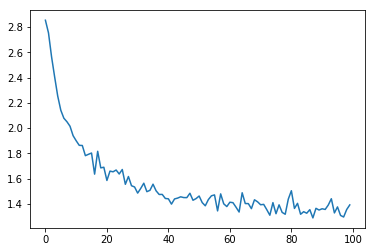

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

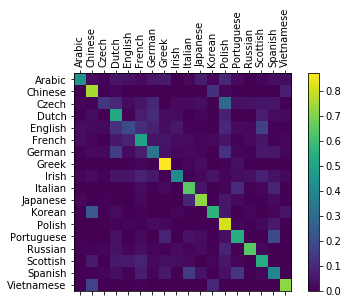

In [22]:
#Evaluation

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [24]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensorArray(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.03) Polish
(-1.17) Russian
(-1.69) Czech

> Jackson
(-0.75) Scottish
(-1.71) French
(-2.00) English

> Satoshi
(-0.86) Italian
(-1.31) Polish
(-1.76) Japanese


# Task 2 - Generating Names with char-level RNN

In [26]:
#The data is the same as used in the previous task

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


In [29]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories+input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories+input_size+hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size+output_size, output_size)
        
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category,input,hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((output, hidden), 1)
        output = seld.o2o(output_combined)
        
        output = self.dropout(output)
        output = self.softmax(output)
        
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [37]:
#get a random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep, the input is category concatenated with the letter input (the current letter) and the hidden state from previous timestep. The output is the next_letter and hidden_state

https://www.programiz.com/python-programming/methods/list/index

In [56]:

def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    
    for i in range(len(line)):
        letter = line[i]
        tensor[i][0][all_letters.find(letter)] = 1
        
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    print(letter_indexes)
    letter_indexes.append(n_letters - 1) # EOS
    print(torch.LongTensor(letter_indexes))
    return torch.LongTensor(letter_indexes)
    

In [63]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    print(target_line_tensor)
    return category_tensor, input_line_tensor, target_line_tensor

In [64]:
randomTrainingExample()

[8, 13, 20, 10, 7, 8, 13]
tensor([ 8, 13, 20, 10,  7,  8, 13, 58])
tensor([ 8, 13, 20, 10,  7,  8, 13, 58])


(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 